# Predicting World Happiness 

This report seeks to predict the happiness levels from the 2019 U.N. World Happiness Data.

I combined two datasets to use throughout this notebook - the original 2019 U.N. Happiness data, and CIA Worldfactbook data from 2013. The CIA data isn't as recent as the U.N. data, but it was the most recent data that was easily available in the format I needed. I'm choosing to include it because theoretically, the country-level values would not vary so much over 6 years that they are no longer helpful for predicting overall happinness. I will use automatic feature selection and look at the performance of my models to determine if the extended data is helpful at all. 

# Import, Clean, & Preprocess Data

In [ ]:
# Import data
import pandas as pd
full_data = pd.read_csv("/content/happy_and_factbook.csv")

In [ ]:
# Clean up final data
full_X = full_data.drop(['Unnamed: 0', 'Happiness_level', 'name', 'Country.or.region', 'sub.region'], axis=1)
full_y = full_data['Happiness_level']

In [ ]:
# Train/Test/Split Data 
from sklearn.model_selection import train_test_split

full_X_train, full_X_test, full_y_train, full_y_test = train_test_split(full_X, full_y, test_size=.33, random_state=42)

In [ ]:
# Set up preprocessor for full data:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
np.random.seed(56)

# full Data 
full_numeric_features=full_X.columns.tolist()
full_numeric_features.remove('region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
full_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, full_numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit preprocessor object
full_preprocess=full_preprocessor.fit(full_X_train) 

In [ ]:
#Function to transform data with preprocessor (full)
def full_preprocessor(data):
    preprocessed_data=full_preprocess.transform(data)
    return preprocessed_data

In [46]:
# Check shape for keras input:
print(full_preprocessor(full_X_train).shape)

(105, 22)


# Exploring Bivariate Results

Describe any relationships you see between particular features and the target variable

In [ ]:
# Check distribution of prediction variable: 
full_data.groupby('Happiness_level')[['Happiness_level']].count()

,Happiness_level
Happiness_level,
Average,31
High,33
Low,31
Very High,31
Very Low,31


I began by checking the distribution of the dependent variable, happiness level. The categories are evenly distributed, so it looks like accuracy can be an appropriate metric to use to compare the upcoming models. 

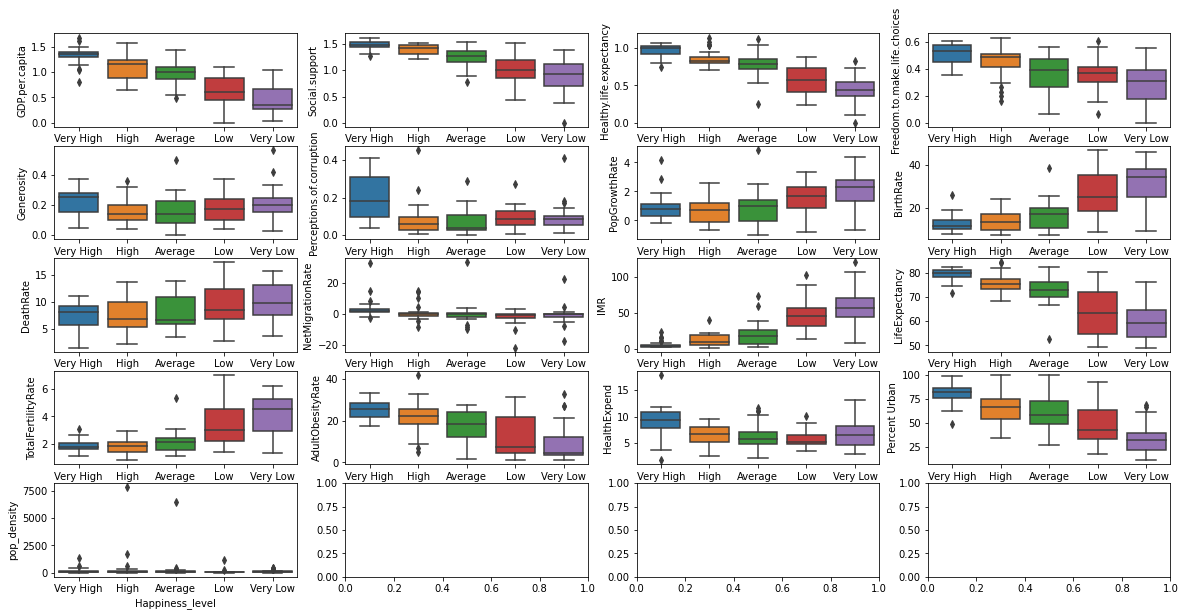

In [ ]:
#examine relationships between IVs and DV
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(5, 4, figsize=(20, 10))
for var, subplot in zip(full_numeric_features, ax.flatten()):
    sns.boxplot(x='Happiness_level', y=var, data=full_data, ax=subplot)

I then made a boxplot for every numeric variable in the data set to explore the relationships between the independent variables and the dependent variable, happiness level. 

The clearest relationships seem to be with the first couple of variables in the original data set: GDP per capita, Social Support, Healthy Life Expectency, and Freedom to make life choices. Of the additonal variables from the CIA World Factbook, Adult Obesity Rate, IMR (Infant Mortality Rate), and Percent Urban seem to have the strongest relationships with the dependent variable. Generosity, Population Growth Rate, Death Rate, and Fertility Rate all seem to have a lot of inter quartile-range overlap and will probably be less helpful in predicting Happiness level. 

It looks like, on average, countries with higher GDPs, higher levels of social support, and higher life expectancies are more likely to have higher levels of happiness. Generosity and Death Rate don't seem to have a clear distinction at different levels of happiness. It's interesting that countries with "very high" levels of happiness also seem to generally have higher perceptions of corruption than countries at other levels of happiness. 

It looks like countries with the highest fertility rates and highest infant mortality rates (IMR) are most likely to have "low" or "very low" levels of happiness, though there are not clear distinctions between those two categories or between the "average", "high", and "very high" categories. 

Because of outliers, Net Migration Rate and Population Density are hard to examine in this chart, so I'll take a closer look at them below. 

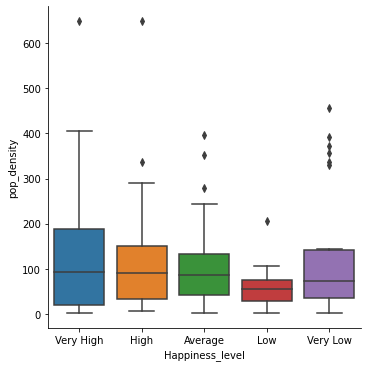

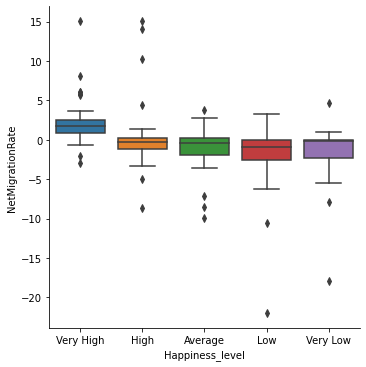

In [ ]:
# Zoom in on pop_density & net_migration_rate to get a closer look at relationships
pop_dense_no_ouliers = full_data[full_data["pop_density"] < 1000]
sns.catplot(x="Happiness_level", y="pop_density", kind="box", data=pop_dense_no_ouliers)

migration_rate_no_ouliers = full_data[full_data["NetMigrationRate"] < 20 ]
sns.catplot(x="Happiness_level", y="NetMigrationRate", kind="box", data=migration_rate_no_ouliers)

Here it looks like there is a lot of overlap between the interquartile range of different categories, so neither of these variables are likely to be particularly helpful in predicting average happiness level. 

I'll use Automatic feature selection next to help determine how to best reduce the dimensionality of the dataset for my models. 

#  Examine features that predict happiness categories using one or more models that allow for automatic feature selection 

Explain any meaningful findings

In [ ]:
# Random Forest:

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=200)
formodel = forest.fit(full_preprocessor(full_X_train), full_y_train)

print(formodel.feature_importances_)

[0.14323758 0.08456572 0.09100814 0.05577517 0.03670072 0.05068049
 0.0300411  0.03881359 0.03602441 0.03988895 0.07475481 0.0625094
 0.0519115  0.03959398 0.03701346 0.06554884 0.02911397 0.01181123
 0.01098382 0.00764553 0.0020979  0.00027969]


I began by using a Random Forest model to identify feature importance. None of the variables seem to explain a significant portion of the variation in happiness level, so I used the list of feature importance values to determine how many variables to tell the Recursive Feature Elimination function to keep in the next step. 

The most important variable has a score a little over .1, so I counted the number of variables that had a score over .05, or half that of the most important variable and used that number as a cutoff point. 

That means keeping 9 variables, which I use in the recursive function below. 

In [ ]:
# Use Recursive Feature Elimination to Choose Model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE

estimator = GradientBoostingClassifier().fit(full_preprocessor(full_X_train), full_y_train) 

selector = RFE(estimator, 7, step=1) # step tells RFE how many features to remove each time model features are evaluated

selector = selector.fit(full_preprocessor(full_X_train), full_y_train) # fit RFE estimator.

print("Num Features: %d" % selector.n_features_)
print("Selected Features: %s" % selector.support_)

#Transform X data with Feature Selection
X_new = selector.transform(full_preprocessor(full_X))
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X_new, full_y, test_size=.33, random_state=42)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_features_to_select=7 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


Num Features: 7
Selected Features: [ True  True  True False False  True False  True False False  True False
  True False False False False False False False False False]


The point of incorporating additional data from the CIA WorldFactbook into the U.N. Data set was to see if it would be helpful in making predictions, According to the "Selected features" output above, 3 variables from the Worldfactbook Data Set were helpful enough to still be included at the end of the dimension reduction process.

# Run prediction models to try to predict World Happiness well.

In [ ]:
# KNN Classifier: Feature Selected Data

# Tune parameters
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 15, 2)} 
grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10) 
grid.fit(new_X_train, new_y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(new_X_test, new_y_test)))

# Save data for final comparison
knn_params = format(grid.best_params_)
knn_cv_score = format(grid.best_score_)
knn_test_score = format(grid.score(new_X_test, new_y_test))

best mean cross-validation score: 0.519
best parameters: {'n_neighbors': 1}
test-set score: 0.327


In [45]:
# Gradient Boosted Classifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': np.arange(100, 1000, 100), 
              'learning_rate':(.01, .001, .0001), 
              'max_depth':(2, 3, 4)}

grid = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=5) 
grid.fit(new_X_train, new_y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(new_X_test, new_y_test)))

# Save data for final comparison
gb_params = format(grid.best_params_)
gb_cv_score = format(grid.best_score_)
gb_test_score = format(grid.score(new_X_test, new_y_test))

model_to_submit = GradientBoostingClassifier(learning_rate=.01, max_depth=3, n_estimators=900)
model_to_submit = model_to_submit.fit(new_X_train, new_y_train)

best mean cross-validation score: 0.657
best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 900}
test-set score: 0.481


In [ ]:
# Install libraries for Neural Net:
!pip install scikit-learn --upgrade  # ghet latest version on sckikitlearn 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1    

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
# Neural Network Model: 
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import numpy
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from keras.optimizers import SGD

# fix random seed for reproducibility
numpy.random.seed(7)

def create_model(learn_rate=0.01):
  model = Sequential()
  model.add(Dense(128, input_dim=7, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(5, activation='softmax')) 
  optimizer = SGD(lr=learn_rate)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, verbose=0)

# Grid Search
learn_rate = [0.001, 0.01, .1]
epochs = [500, 600, 700]
param_grid = dict(learn_rate=learn_rate, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(new_X_train, pd.get_dummies(new_y_train))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Save data for final comparison
nn_params = format(grid_result.best_params_)
nn_cv_score = format(grid_result.best_score_)

Best: 0.552381 using {'epochs': 700, 'learn_rate': 0.01}
0.428571 (0.060234) with: {'epochs': 500, 'learn_rate': 0.001}
0.533333 (0.097124) with: {'epochs': 500, 'learn_rate': 0.01}
0.533333 (0.081927) with: {'epochs': 500, 'learn_rate': 0.1}
0.466667 (0.101686) with: {'epochs': 600, 'learn_rate': 0.001}
0.542857 (0.077372) with: {'epochs': 600, 'learn_rate': 0.01}
0.495238 (0.064594) with: {'epochs': 600, 'learn_rate': 0.1}
0.428571 (0.095238) with: {'epochs': 700, 'learn_rate': 0.001}
0.552381 (0.048562) with: {'epochs': 700, 'learn_rate': 0.01}
0.504762 (0.088320) with: {'epochs': 700, 'learn_rate': 0.1}


In [ ]:
# Evaluate NN on held out test data 

prediction_index=grid_result.predict(new_X_test)
labels=pd.get_dummies(new_y_train).columns
predicted_labels=list(map(lambda x: labels[x], prediction_index))   

from sklearn.metrics import accuracy_score
print("Accuracy: {:.2f}%".format(accuracy_score(new_y_test, predicted_labels) * 100))
nn_test_score = format(accuracy_score(new_y_test, predicted_labels))

Accuracy: 46.15%


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# Support Vector Machine
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1E6, gamma=.1) 

param_grid = {'C': np.logspace(-2, 8, 6), 'gamma': np.logspace(-2, 8, 6), 'kernel':('linear', 'poly', 'rbf')}
grid = GridSearchCV(estimator=clf, param_grid=param_grid)
grid_result = grid.fit(new_X_train, new_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Use best params on test data 
print("test-set score: {:.3f}".format(grid_result.score(new_X_test, new_y_test)))

# Save data for final comparison
svm_params = format(grid_result.best_params_)
svm_cv_score = format(grid_result.best_score_)
svm_test_score = format(grid_result.score(new_X_test, new_y_test))

Best: 0.533333 using {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 0.001, 'kernel': 'linear'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 0.001, 'kernel': 'poly'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 0.01, 'kernel': 'linear'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 0.01, 'kernel': 'poly'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 0.1, 'kernel': 'linear'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 0.1, 'kernel': 'poly'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 1.0, 'kernel': 'linear'}
0.428571 (0.052164) with: {'C': 0.001, 'gamma': 1.0, 'kernel': 'poly'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.247619 (0.019048) with: {'C': 0.001, 'gamma': 10.0, 'kernel': 'linear'

# Model Comparison

In [ ]:
all_results = pd.DataFrame({"Model": ("K Nearest Neighbors", "Gradient Boosted", "Neural Network", "Support Vector Machine"),
                            "Best Train CV Score": (knn_cv_score, gb_cv_score, nn_cv_score, svm_cv_score),
                            "Test Score": (knn_test_score, gb_test_score, nn_test_score, svm_test_score),
                            "Parameters": (knn_params, gb_params, nn_params, svm_params)})
all_results

,Model,Best Train CV Score,Test Score,Parameters
0,K Nearest Neighbors,0.5190909090909089,0.3269230769230769,{'n_neighbors': 1}
1,Gradient Boosted,0.6380952380952382,0.4807692307692308,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est..."
2,Neural Network,0.5619047820568085,0.46153846153846156,"{'epochs': 700, 'learn_rate': 0.01}"
3,Support Vector Machine,0.5333333333333334,0.34615384615384615,"{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}"


The best perfoming model was the Gradient Boosted Ensemble model, with a test accuracy of 48%. I chose the hyperparameters with GridSearch CV, and the best combination of parameters was: learning_rate': 0.01, 'max_depth': 3, and 'n_estimators': 800. 

The MLP nural network model was second best, with an accuracy of 46%. The best combination of parameters was 700 epochs and a learning rate of .01. 

The worst performing model was K-Nearest Neighbors, with the number of neighbors equal to 1. 

All of the models are subject to a fairly significant overfitting problem, which is probably to be expected with a small dataset like this. In an effort to fix the problem, I re-ran the models with only the 3 most helpful predicting variables, but ultimately that reduced model performance as well as overfitting, so I kept the original dimensionally-reduced dataset with 9 variables. 

I was surprised that the Support Vector Machine model didn't perform better, as SVMs are designed to work well with small data sets and seem to comprise some of the top models on the AI Model Share leaderboard for this dataset. 

# Uploading to AI Model Share

In [ ]:
#install aimodelshare library
! pip install aimodelshare --upgrade --extra-index-url https://test.pypi.org/simple/ 

Looking in indexes: https://pypi.org/simple, https://test.pypi.org/simple/
     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 194kB 5.9MB/s 
     |████████████████████████████████| 4.1MB 21.3MB/s 
     |████████████████████████████████| 7.2MB 41.8MB/s 
     |████████████████████████████████| 9.0MB 216kB/s 
     |████████████████████████████████| 22.2MB 52.4MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
     |████████████████████████████████| 133kB 47.1MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115928 sha256=8e28e91f3102d56e6b774e0423855014f675fcf9fd612e498181e7aed031215c
  Stored in directory: /root/.cache/pip/wheels/af/19/30/1ea0cad502dcb4e66ed5a690279628c827aea38bbbab75d5ed
Successfully built fire
ERROR: botocore 1.20.3 has requiremen

In [ ]:
#Save preprocessor function to local "preprocessor.zip" file for leaderboard submission
import aimodelshare as ai
ai.export_preprocessor(full_preprocessor,"")

In [35]:
from aimodelshare.aimsonnx import model_to_onnx, _get_metadata
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('float_input', FloatTensorType([None, 7]))] 

# transform sklearn model to ONNX
onnx_model_sklearn = model_to_onnx(model_to_submit, framework='sklearn',                 
                                   initial_types=initial_type,                  
                                   transfer_learning=False,
                                   deep_learning=False,
                                   task_type='classification')

# Save model to local .onnx file
with open("onnx_model_sklearn.onnx", "wb") as f:
    f.write(onnx_model_sklearn.SerializeToString())

In [36]:
import aimodelshare as ai

#aimodelshare username and password
username="TheStreett"
password="----"

# Load from pkl file
import pickle
with open("aws_creds_worldhappiness.pkl", 'rb') as file:
    aws_key,aws_password,region = pickle.load(file)

token=ai.aws.get_aws_token(username, password)
awscreds=ai.aws.get_aws_client(aws_key=aws_key, aws_secret=aws_password, aws_region=region)

In [ ]:
predictions_sklearn = model_to_submit.predict(new_X_test)

In [41]:
# test submit_model()
ai.submit_model("onnx_model_sklearn.onnx",
                "https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds,prediction_submission=predictions_sklearn,
                preprocessor="preprocessor.zip")

True

In [44]:
import pandas
data=ai.get_leaderboard("https://z69mxrxdz5.execute-api.us-east-1.amazonaws.com/prod/m",
                token,awscreds)
ai.stylize_leaderboard(data, category="classification")

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,relu_act,softmax_act,loss,optimizer,model_config,username,version
0,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,96
1,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,nan,nan,"{'C': 5, 'break_ties': False, ...",kka2120,90
2,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,67
3,53.85%,53.24%,59.39%,55.03%,sklearn,nan,nan,SVC,nan,110.000000,nan,nan,nan,nan,nan,"{'C': 10, 'break_ties': False,...",prajseth,94
4,51.92%,52.34%,56.79%,53.33%,keras,True,True,Sequential,4.000000,35205.000000,4.000000,3.000000,1.000000,str,SGD,"{'name': 'sequential_5', 'laye...",prajseth,15
5,50.00%,50.50%,55.44%,51.52%,keras,True,True,Sequential,5.000000,201733.000000,5.000000,4.000000,1.000000,str,SGD,"{'name': 'sequential_8', 'laye...",prajseth,30
6,50.00%,50.49%,55.78%,51.48%,keras,True,True,Sequential,4.000000,135941.000000,4.000000,3.000000,1.000000,str,SGD,"{'name': 'sequential_9', 'laye...",prajseth,34
7,50.00%,50.22%,56.03%,51.48%,keras,True,True,Sequential,4.000000,185705.000000,4.000000,3.000000,1.000000,str,SGD,"{'name': 'sequential_7', 'laye...",prajseth,24
8,50.00%,50.29%,53.27%,50.65%,keras,nan,True,Sequential,5.000000,18437.000000,5.000000,4.000000,1.000000,str,SGD,"{'name': 'sequential_5', 'laye...",TheStreett,70
9,48.08%,47.87%,53.24%,49.55%,keras,True,True,Sequential,4.000000,35205.000000,4.000000,3.000000,1.000000,str,SGD,"{'name': 'sequential_10', 'lay...",prajseth,39


As of the time of writing, my best performing modelb with this extended data set (The gradient boosted classifier) ranks 13 out of 91 models. The performance is respectable, but it should be noted that the MLP neural network model I ran originally, with tuning paramaters by hand (instead of using GridSearch CV) and without adding additional predictors from the CIA World Factbook, is still outperforming my top model with the additional World Factbook data. That  model is ranked 8 out of 91 at the time of writing, and contained 5 layers (4 with relu transformations, 1 with softmax).

# Areas for Growth

To improve these models, I would continue to fine-tune the number of variables that I included in the Recursive Feature Elimination process. I would tune additional parameters for the neural network model, including number of layers and types of transformations. I would continue to expand the range of estimators for the gradient boosted model, and I would continue to explore other types of models that may be a better fit for this data set. 